This is to do pca on the full 1000 Genomes genotype dataset.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%%bash

# Step 1: Create a directory and download 1000 Genomes VCF files
mkdir -p onekgenomes
cd onekgenomes
prefix="ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr"
suffix=".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
for chr in {1..22}; do
    wget "${prefix}${chr}${suffix}" "${prefix}${chr}${suffix}.tbi"
done

# Step 2: Download the 1000 Genomes PED file
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/working/20130606_sample_info/20130606_g1k.ped

# Step 3: Download the GRCh37 / hg19 reference genome
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/human_g1k_v37.fasta.gz
wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/human_g1k_v37.fasta.fai
gunzip human_g1k_v37.fasta.gz

# Step 4: Convert VCF to BCF
for chr in {1..22}; do
    bcftools norm -m-any --check-ref w -f human_g1k_v37.fasta \
      ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz | \
      bcftools annotate -x ID -I +'%CHROM:%POS:%REF:%ALT' | \
      bcftools norm -Ob --rm-dup both \
      > ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.bcf
    
    bcftools index ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.bcf

done

# Step 5: Convert BCF files to PLINK format
for chr in {1..22}; do
    plink --noweb \
      --bcf ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.bcf \
      --keep-allele-order \
      --vcf-idspace-to _ \
      --const-fid \
      --allow-extra-chr 0 \
      --split-x b37 no-fail \
      --make-bed \
      --out ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes
done

# Step 6: Exclude non-coding strand variants (optional, for microarray studies)

# Step 7: Prune variants from each chromosome
mkdir -p Pruned
for chr in {1..22}; do
    plink --noweb \
      --bfile ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes \
      --maf 0.10 --indep 50 5 1.5 \
      --out Pruned/ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes

    plink --noweb \
      --bfile ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes \
      --extract Pruned/ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.prune.in \
      --make-bed \
      --out Pruned/ALL.chr"${chr}".phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes
done

# Step 8: Get a list of all PLINK files
find . -name "*.bim" | grep -e "Pruned" > ForMerge.list
sed -i 's/.bim//g' ForMerge.list

# Step 9: Merge all projects into a single PLINK file
plink --merge-list ForMerge.list --out Merge

# Step 10: Perform PCA
plink --bfile Merge --pca

In [9]:
# Read in the eigenvectors (PLINK output)
eigenvec = pd.read_csv('onekgenomes/plink.eigenvec', delim_whitespace=True, header=None)
eigenvec.set_index(eigenvec.iloc[:, 1], inplace=True)
eigenvec = eigenvec.iloc[:, 2:]
eigenvec.columns = [f'Principal Component {i+1}' for i in range(eigenvec.shape[1])]

/var/folders/xs/gzfsrmhs1q11tsm80s9b2l7h0000gn/T/ipykernel_12171/447517797.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  eigenvec = pd.read_csv('onekgenomes/plink.eigenvec', delim_whitespace=True, header=None)


In [10]:
# Read in the PED data
PED = pd.read_csv('onekgenomes/20130606_g1k.ped', sep='\t', header=0)
PED = PED[PED['Individual ID'].isin(eigenvec.index)]
PED = PED.set_index('Individual ID').loc[eigenvec.index]
assert all(PED.index == eigenvec.index), "Mismatch in individual IDs"

In [11]:
# load superpopulations, those in EUR data
metadata = pd.read_csv('onekgenomes/igsr_samples.tsv', sep='\t', header=0)
PED = PED.merge(metadata[['Sample name', 'Superpopulation code']], how='left', left_index=True, right_on='Sample name')

df = pd.read_csv("data/LDREF_filtered/1000G.EUR.1_filtered.fam", delim_whitespace=True, header=None)
sample_list = df[0].tolist()
PED['in_dataset'] = PED['Sample name'].apply(lambda x: True if x in sample_list else False)

/var/folders/xs/gzfsrmhs1q11tsm80s9b2l7h0000gn/T/ipykernel_12171/1172999036.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("data/LDREF_filtered/1000G.EUR.1_filtered.fam", delim_whitespace=True, header=None)


In [12]:
PED['Superpopulation code'].value_counts()

Superpopulation code
AFR        661
EAS        504
EUR        502
SAS        489
AMR        347
EUR,AFR      1
Name: count, dtype: int64

In [13]:
eigenvec = eigenvec.drop('HG01783')
PED = PED[PED['Superpopulation code'] != 'EUR,AFR']

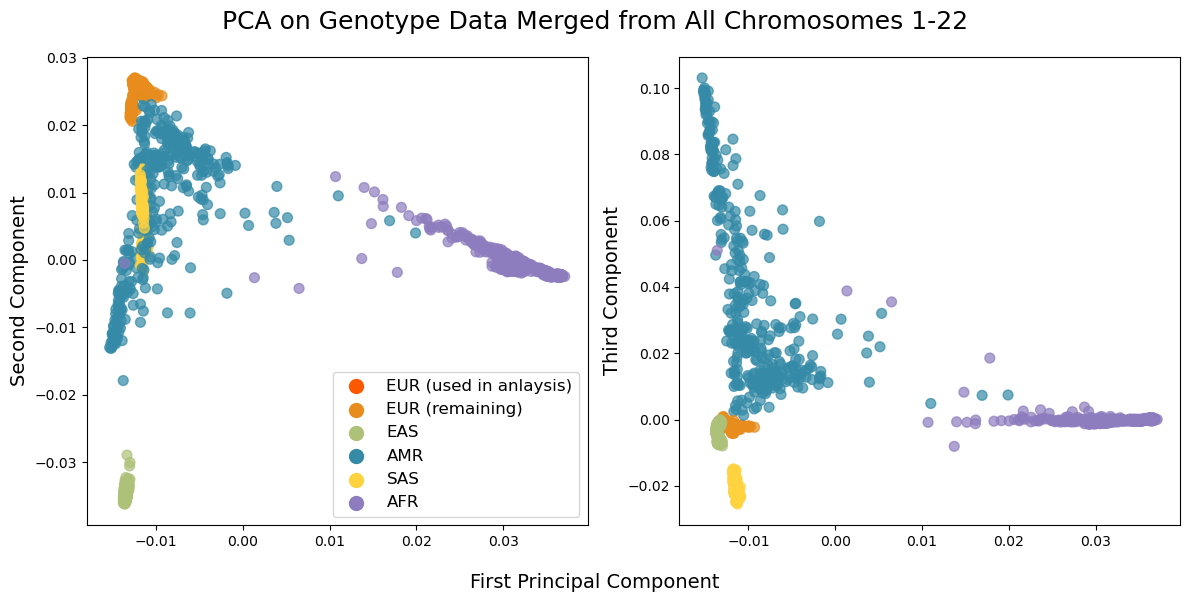

In [14]:
PED['Color'] = PED['Superpopulation code'].map({'EUR_True': '#fc5800', 'EUR': '#e78c1d', 
                                                   'EAS': '#adc178' , 'AMR': '#348aa7', 'SAS': '#ffd23f',
                                                   'AFR': '#8e7dbe'})

# Create PCA plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('PCA on Genotype Data Merged from All Chromosomes 1-22', fontsize=18)
fig.supxlabel('First Principal Component', fontsize=14)

# Plot PC1 vs PC2
axes[0].scatter(eigenvec.iloc[:, 0], eigenvec.iloc[:, 1], c=PED['Color'], s=50, alpha=0.7)
axes[0].set_ylabel('Second Component', fontsize=14)

# Plot PC1 vs PC3
axes[1].scatter(eigenvec.iloc[:, 0], eigenvec.iloc[:, 2], c=PED['Color'], s=50, alpha=0.7)
axes[1].set_ylabel('Third Component', fontsize=14)

# Legend
legend_colors = ['#fc5800', '#e78c1d', '#adc178', '#348aa7', '#ffd23f', '#8e7dbe']
legend_labels = [
    'EUR (used in anlaysis)',
    'EUR (remaining)', 
    'EAS', 'AMR', 'SAS', 'AFR'
]
for i, (color, label) in enumerate(zip(legend_colors, legend_labels)):
    axes[0].scatter([], [], c=color, label=label, s=100)
axes[0].legend(title='', loc='lower right', fontsize=12)

plt.tight_layout()
plt.savefig('out/plots/pca_by_population.png', dpi=350)
plt.show()